# Clustering analysis

There are two datasets that have similar information for France and South Korea, respectively. So, the idea is to merge those datasets and see if we can find clusters. 

You can find the links to the data here: 
- France: https://www.kaggle.com/lperez/coronavirus-france-dataset
- South Korea: https://www.kaggle.com/kimjihoo/coronavirusdataset

In [1]:
import pandas as pd
import numpy as np
import random
from sklearn import preprocessing
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from kneed import KneeLocator
import geopandas
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

## Load the data and check missing values
Let's load the data for both datasets and see how many NAs values it has. NAs values corresponds to missing or empty information. Decision should be made for each particular column to prepare the data for the analysis. 

In [2]:
def load_data(data_path):
    df = pd.read_csv(data_path + '/patient.csv')
    df['released_date'] = pd.to_datetime(df['released_date'])
    df['confirmed_date'] = pd.to_datetime(df['confirmed_date'])
    df['month'] = df['confirmed_date'].dt.month
    df['day'] = df['confirmed_date'].dt.day
    return df

In [3]:
df_france = load_data('coronavirusdataset_france')
df_france.isnull().sum()

id                  2067
sex                 1851
birth_year          1936
country                1
region                 1
departement          195
city                1804
group               1905
infection_reason    1906
infection_order     2068
infected_by         2056
contact_number      2073
confirmed_date         4
released_date       2064
deceased_date       2048
status              1481
health              1849
source               199
comments            1637
month                  4
day                    4
dtype: int64

In [4]:
df_south_korea = load_data('coronavirusdataset_south_korea')
df_south_korea.isnull().sum()

patient_id             0
sex                 7190
birth_year          7203
country                0
region              7432
disease             7841
group               7783
infection_reason    7715
infection_order     7833
infected_by         7799
contact_number      7816
confirmed_date         0
released_date       7813
deceased_date       7833
state                  0
month                  0
day                    0
dtype: int64

## Resolve missing values

- With the objective of keeping the necesary data, some of the columns are removed such as department, comments, health consiedered not important for the analysis. 
- From the birth date, we can create the age variable, substracting it to the actual date. The missing information will be filled with random numbers draw from a distribution. The information related to the age distribution of the population can be found:     
 *France:* https://www.indexmundi.com/france/demographics_profile.html  
 *South Korea:* https://www.indexmundi.com/south_korea/demographics_profile.html
 
So, the 'simulate_age' function is create in order to simulate the population's age based on the available data. 
 

In [5]:
df_france.drop(['departement','region','comments', 'id', 'infected_by','health','city','source'],axis=1,inplace=True)
df_south_korea.drop(['region','disease','patient_id','infected_by'], axis=1, inplace=True)

In [6]:
def simulate_age(ranges, percents, total_pop):
    simulated_pop = np.array(0)
    for (low, high), percent in zip(ranges, percents):
        simulated_pop = np.append(simulated_pop, 
                  np.random.randint(low=low, high=high, size=int(total_pop*percent/100)))
    return simulated_pop

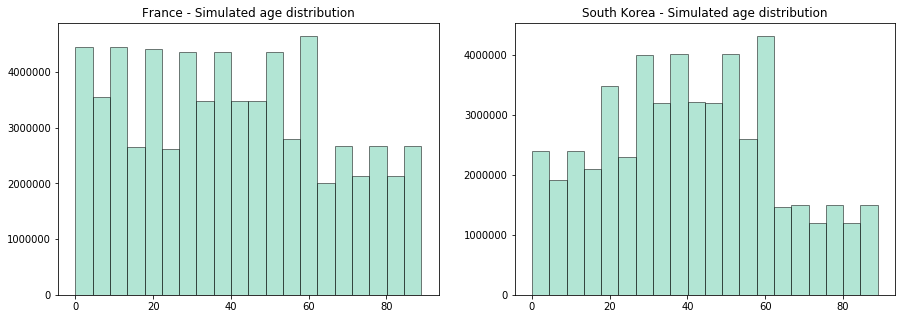

In [7]:
#France
france_population = 67364357

'''
0-14 years: 18.48% 
15-24 years: 11.8% 
25-54 years: 37.48% 
55-64 years: 12.42%
65 years and over: 19.82%
'''
ranges = [(0,14),(15,24),(25,54),(55,64),(65,90)]
percents = [18.48,11.8,37.48,12.42,19.82]
france_simulated_pop = simulate_age(ranges, percents, france_population)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
ax1.hist(france_simulated_pop,bins=20, color='mediumaquamarine', edgecolor='k', alpha=0.5)
ax1.set_title('France - Simulated age distribution')

#South Korea
south_korea_population = 51418097

'''
0-14 years: 13.03% 
15-24 years: 12.19%
25-54 years: 45.13%
55-64 years: 15.09% 
65 years and over: 14.55% 
'''
percents = [13.03,12.19,45.13,15.09,14.55]
south_korea_simulated_pop = simulate_age(ranges, percents, south_korea_population)

ax2.hist(south_korea_simulated_pop,bins=20, color='mediumaquamarine', edgecolor='k', alpha=0.5)
ax2.set_title('South Korea - Simulated age distribution')
plt.show()

Now, let's create the age column, and fill the missing values with a random value choosen from the distributions that we just simulated.

In [8]:
import math
actual_year = pd.to_datetime('today').year
def calculate_age(x):
    if math.isnan(x):
        return x
    else:
        return int(actual_year - x)

#France
df_france['age'] = df_france['birth_year'].apply(calculate_age)
df_france.fillna({'age':int(random.choice(france_simulated_pop))}, inplace=True)
df_france.drop(['birth_year'], axis=1, inplace=True)

#South Korea
df_south_korea['age'] = df_south_korea['birth_year'].apply(calculate_age)
df_south_korea.fillna({'age':int(random.choice(south_korea_simulated_pop))}, inplace=True)
df_south_korea.drop(['birth_year'], axis=1, inplace=True)

For sex missing values, we can draw a random number with a value of probability based on the sex ratio for each population.

In [9]:

'''
Considering m as men and w as women. 
m/w=ratio -> m=ration*w
m+w=total_pop
-> ratio*w +w=total_pop -> (ratio+1)*w=total_pop -> w=total_pop/(ratio+1)
we should divide w by the total in order to get the probability of being women 
'''
def calculate_values(ratio, total_pop):
    w = (france_population/(1+ratio))/total_pop
    m = 1 - w
    return (w,m)


# France
# total population: 0.96 male(s)/female (2018 est.)
w,m = calculate_values(0.96, france_population)
#choice among 0 (woman) and 1 (man) with the calculated probabilities
df_france['sex'] = df_france['sex'].str.lower()
df_france["sex"].replace({"male\xa0?": "male"}, inplace=True)
df_france.fillna({'sex': np.random.choice(['female','male'],p=[w,m])}, inplace=True)

# South Korea
# total population: 1 male(s)/female (2018 est.)
w,m = calculate_values(1, south_korea_population)
df_south_korea['sex'] = df_south_korea['sex'].str.lower()
df_south_korea["sex"].replace({"male\xa0?": "male"}, inplace=True)
df_south_korea.fillna({'sex': np.random.choice(['female','male'],p=[w,m])}, inplace=True)

Since the status column for France's dataset and the state column for South Korea's dataset have the same meaning, we can rename the column for one of the datasets, and update the values to be the same categories.

In [10]:
df_france.rename({'status':'state'}, axis=1, inplace=True)
df_france['state'] = df_france['state'].apply(lambda x: 'isolated' if (x=='hospital' or x=='home isolation') else x)

- The values for the country variable that are empty will be filled with France or South Korea, respectevily.
- A new category 'Unkown' will be created for infection_reason, group, status variables
- A new category for infection_order is added with code 0 
- The empty values for contact number will be filled with 0 

In [11]:
df_france.fillna({'country':'France','infection_reason':'Unkown','group':'Unkown', 
                  'state':'Unknown','infection_order':0, 'contact_number':0} ,
                 inplace=True)

df_south_korea.fillna({'infection_reason':'Unkown','group':'Unkown', 
                       'infection_order':0, 'contact_number':0, 
                       'state':'Unknown'} ,
                 inplace=True)

Let's check now which are the missing values that still  need to be resolved.

In [12]:
df_france.isnull().sum()

sex                    0
country                0
group                  0
infection_reason       0
infection_order        0
contact_number         0
confirmed_date         4
released_date       2064
deceased_date       2048
state                  0
month                  4
day                    4
age                    0
dtype: int64

In [13]:
df_south_korea.isnull().sum()

sex                    0
country                0
group                  0
infection_reason       0
infection_order        0
contact_number         0
confirmed_date         0
released_date       7813
deceased_date       7833
state                  0
month                  0
day                    0
age                    0
dtype: int64

Nice!, we don't have too much left. 
Now we need to resolve released_date and deceased_date empty values. 
- If released_date is empty, it means that the person still has the virus. 
- If deceased_date is empty, it means that the person did not died. 

So, we can calculate the infection duration in days and remove the other 3 variables.  
And transform deceased_date to a binary column, indicated if the person died or not.

In [14]:
df_france['released_date'] = df_france[['released_date','deceased_date']].fillna(df_france['deceased_date'])
df_france['released_date'] = df_france[['released_date']].fillna(pd.to_datetime('today'))
df_france['infection_duration'] = pd.to_datetime(df_france['released_date']).sub(df_france['confirmed_date'], axis=0)
df_france = df_france[df_france['infection_duration'].dt.days>=0]
df_france['infection_duration'] = df_france['infection_duration'].dt.days
df_france.drop(['released_date','confirmed_date','deceased_date'], axis=1, inplace=True)

df_south_korea['released_date'] = df_south_korea[['released_date','deceased_date']].fillna(df_south_korea['deceased_date'])
df_south_korea['released_date'] = df_south_korea[['released_date']].fillna(pd.to_datetime('today'))
df_south_korea['infection_duration'] = pd.to_datetime(df_south_korea['released_date']).sub(df_south_korea['confirmed_date'], axis=0)
df_south_korea = df_south_korea[df_south_korea['infection_duration'].dt.days>=0]
df_south_korea['infection_duration'] = df_south_korea['infection_duration'].dt.days
df_south_korea.drop(['released_date','confirmed_date','deceased_date'], axis=1, inplace=True)

In [15]:
df_france.columns

Index(['sex', 'country', 'group', 'infection_reason', 'infection_order',
       'contact_number', 'state', 'month', 'day', 'age', 'infection_duration'],
      dtype='object')

In [16]:
df_south_korea.columns

Index(['sex', 'country', 'group', 'infection_reason', 'infection_order',
       'contact_number', 'state', 'month', 'day', 'age', 'infection_duration'],
      dtype='object')

## Data Fusion
Finally, we are ready to put the two datasets together and start our analysis.

In [17]:
df = df_france.append(df_south_korea, sort=False)

In [18]:
df.isnull().sum()

sex                   0
country               0
group                 0
infection_reason      0
infection_order       0
contact_number        0
state                 0
month                 0
day                   0
age                   0
infection_duration    0
dtype: int64

## Transform to dummies the categorical variables

In [19]:
df = pd.concat([df, pd.get_dummies(df['sex'])], axis=1)
df = pd.concat([df, pd.get_dummies(df['country'])], axis=1)
df = pd.concat([df, pd.get_dummies(df['state'], drop_first=True)], axis=1)
df = pd.concat([df, pd.get_dummies(df['infection_reason'], drop_first=True)], axis=1)
df = pd.concat([df, pd.get_dummies(df['group'], drop_first=True)], axis=1)

## Dimension reduction

Since we have too many variables, it is difficult to find the pattern among the clusters. 
So, first we can reduce the number of categorical variables by groupping similar categories. 
After, we can apply a dimension reduction technique to reduce the input variables and make the model easier to interpret. 

In [20]:
df = df_france.append(df_south_korea, sort=False)

Transform infection_reason: let's list the possible values for this variable, and group them. The, transform to dummy variables. Drop one since it is implicit from the others. 

In [21]:
df.infection_reason.unique()

array(['visit to Italy', 'contact with patient',
       'visit to Mulhouse religious gathering', 'Unkown',
       'contact with person who visited Italy', 'visit to Egypt',
       'unknown', 'visit to Oise', 'visit to Germany',
       'Visit to Venise, Italy', 'contact with patient in Auray',
       'visit to Mulhouse', 'visit to Milan', 'Italian',
       'visit to Lombardy', 'parishioner', 'Creil military base\xa0?',
       'visit to Senegal', 'visit to Alsace', 'visit in Lombardy',
       'visit to Bretagne', 'Visit in Italy',
       'In contact with someone contamitaminated in Oise',
       'Religious Meeting in Mulhouse', 'work in a medical environment ',
       'Visit family in Oise', 'health professional', 'visit to Wuhan',
       'contact with patient in Japan', 'residence in Wuhan',
       'visit to Thailand', 'contact with patient in Singapore',
       'visit to China', 'visit to Daegu', 'pilgrimage to Israel',
       'contact with patient in Daegu', 'visit to Vietnam',
      

In [22]:
def transform_reason(value):
    if ('religious' in value or 'parishioner' in value):
        return 'religious'
    elif ('visit' in value or 'residence' in value):
        return 'visit'
    elif ('contact' in value):
        return 'contact'
    elif ('medical' in value or 'health professional' in value):
        return 'medical'
    elif ('militar' in value):
        return 'militar'
    elif ('italian' in value):
        return 'italian'
    elif ('pilgrimage' in value):
        return 'pilgrimage'
    else:
        return 'unknown'

df['infection_reason'] = df['infection_reason'].str.lower()
df['infection_reason'] = df['infection_reason'].apply(transform_reason)  
df = pd.concat([df, pd.get_dummies(df['infection_reason'], prefix='infection_reason', prefix_sep='_')], axis=1)
df.drop(['infection_reason_unknown'], axis=1, inplace=True)

Since the 'group' variable provides similar information to infection_reson, it will be removed. 

In [23]:
df.drop(['group'], axis=1, inplace=True)

Let's transform the other categorical variables to dummies: country, state and sex.

In [24]:
df = pd.concat([df, pd.get_dummies(df['country'])], axis=1)
df = pd.concat([df, pd.get_dummies(df['state'], prefix='state', prefix_sep='_')], axis=1)
df = pd.concat([df, pd.get_dummies(df['sex'])], axis=1)

In [25]:
features = df.drop(['country','state','sex','infection_reason'], axis=1)
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
x = StandardScaler().fit_transform(features.values)
pca = PCA(random_state=0)
pca.fit(x)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=0,
    svd_solver='auto', tol=0.0, whiten=False)

In [26]:
#determine number of components with threshold=0.8
n_components=np.where(np.cumsum(pca.explained_variance_ratio_)>0.8)[0][0]+1
#explained variance
v = round(np.cumsum(pca.explained_variance_ratio_)[n_components-1]*100,1)
print(f'It is needed {n_components} components to explain {v}% variance of the data')

It is needed 11 components to explain 80.7% variance of the data


In [27]:
pca = PCA(n_components=n_components)
pcs = pca.fit(x)
components_name = list(range(0, n_components))
components_name = list(map(lambda x: 'PC' + str(x), components_name))
pd.DataFrame(data=pcs.components_, columns = features.columns, index=components_name)

,infection_order,contact_number,month,day,age,infection_duration,infection_reason_contact,infection_reason_italian,infection_reason_medical,infection_reason_militar,...,China,France,Korea,Mongolia,state_Unknown,state_deceased,state_isolated,state_released,female,male
PC0,0.000313,0.002011,0.164359,-0.109692,-0.362518,-0.231668,0.022051,0.001872,0.009389,0.005908,...,0.008652,0.375705,-0.375737,0.001158,0.346118,0.012852,-0.341621,0.017493,0.355894,-0.355894
PC1,0.055996,0.099257,-0.580662,0.554620,-0.138494,0.385469,0.181728,-0.009110,-0.004254,0.000044,...,0.119525,0.036448,-0.045283,0.022562,0.035176,0.048018,-0.085384,0.192748,0.155583,-0.155583
PC2,0.273378,0.375066,0.161556,-0.239386,0.029451,-0.141544,0.321081,0.001996,-0.004445,-0.004113,...,0.426962,-0.066177,0.036858,-0.023054,-0.093687,-0.034712,-0.017367,0.538551,-0.050954,0.050954
PC3,-0.017530,0.008290,0.024274,-0.032187,0.067533,-0.014225,0.071154,-0.004850,-0.009453,-0.030001,...,-0.000541,-0.025005,0.009331,0.635241,0.006249,0.717814,-0.165699,0.045030,-0.050514,0.050514
PC4,0.105852,0.024358,0.026533,-0.055370,-0.054310,0.072142,-0.175563,0.037336,-0.025956,0.119825,...,0.048528,0.057158,-0.065118,0.189143,-0.213146,0.121814,0.203885,-0.107036,0.062272,-0.062272
PC5,0.160085,0.025329,-0.003504,0.021405,0.017462,0.008307,-0.626502,0.033042,0.066563,-0.045489,...,0.084415,0.013829,-0.022449,0.111618,0.060181,0.005468,-0.033985,-0.118766,-0.027654,0.027654
PC6,-0.031212,-0.016887,-0.021907,0.033661,0.000509,-0.014009,0.038639,0.803064,0.368817,-0.337130,...,-0.002507,0.022265,-0.021741,-0.012724,-0.011971,-0.006221,0.009517,0.015761,-0.017950,0.017950
PC7,0.000547,0.004588,0.003136,-0.010480,0.001842,0.012689,0.022290,0.427549,-0.011023,0.884719,...,0.000655,0.004722,-0.005147,0.015675,0.000058,-0.000068,0.000182,-0.001048,-0.000808,0.000808
PC8,0.004261,0.003824,-0.004357,0.005202,-0.010553,-0.000059,0.025973,-0.369653,0.899589,0.204035,...,-0.003795,0.002187,-0.002282,0.014711,-0.014521,-0.000042,0.013515,0.002596,-0.007231,0.007231
PC9,0.035252,0.048505,0.031838,-0.045822,0.002577,0.007499,0.003805,0.177478,0.219226,-0.200495,...,0.017434,-0.010947,0.009004,0.028749,0.001361,0.009813,-0.001775,-0.007441,0.006464,-0.006464


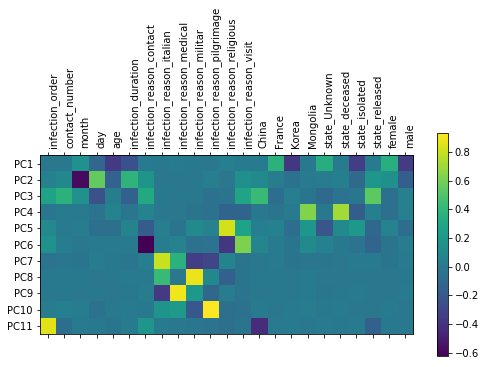

In [28]:
components_range = np.arange(1, n_components+1, 1)
components_names = list(map(lambda x: 'PC' + str(x), components_range))
plt.matshow(pcs.components_,cmap='viridis')
plt.yticks(range(0,n_components), components_names,fontsize=10)
plt.colorbar()
plt.xticks(range(0,len(features.columns)),features.columns,rotation=90,ha='left')
plt.show()

Higer values for the variables means more influence in the principal component. Lower values, means negative influence in the principal components. 
From the matrix, one possible interpretation for the principal componentes is:
- PC1: female who is not isolated and is not from from Korea
- PC2: first months 
- PC3: state released
- PC4: state deceased
- PC5: infection reason not religiuos
- PC6: infection reason visit and not contact 
- PC7: infection reason piligrimage
- PC8: infection reason italian
- PC9: infection reason medical
- PC10: infection order not from China
- PC11: infection order from Mongolia 

## Kmeans Clustering

In [29]:
def elbow_test(df, n_init, max_clusters, max_iter):
    distortions = []
    for i in range(1, max_clusters):
        km = KMeans(
            n_clusters=i, init='random',
            n_init=n_init, max_iter=max_iter,
            tol=1e-04, random_state=0
        )
        km.fit(df)
        distortions.append(km.inertia_)

    plt.plot(range(1, max_clusters), distortions, marker='o')
    plt.xlabel('Number of clusters')
    plt.ylabel('Distortion')
    plt.show()
    
    kn = KneeLocator(
        range(1, max_clusters),
        distortions,
        curve='convex',
        direction='decreasing',
        interp_method='interp1d',
    )
    return kn.knee

def plot_countries(df, title, country_column_name, column_name, n_clusters, legend=False):
    world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
    merged_inner = pd.merge(left=world, right=df, left_on='name',right_on=country_column_name, how='inner')
    cmap = cm.get_cmap('Spectral', n_clusters)
    ax = world.plot(figsize=(20,5), linewidth=0.25, edgecolor='white', color='lightgrey')
    ax.set_title(title)
    
    merged_inner.plot(column=column_name, ax=ax, cmap=cmap, legend=legend)
    plt.show()

In [30]:
def draw_scatter(df, col_1, col_2, cluster_column, num_clusters, title):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
    ax.set_title(title)
    ax.set_xlabel(col_1)
    ax.set_ylabel(col_2)
    labels = list(range(0,num_clusters))
    colors = plt.cm.Spectral(np.linspace(0, 1, num_clusters))
    axs = []
    for i in labels:
        axs.append(ax.scatter(df[df[cluster_column]==i][col_1], df[df[cluster_column]==i][col_2], cmap=colors[i]))
    
    ax.legend(axs, labels, loc='center', bbox_to_anchor=(0.92, 0.84), ncol=1)
    plt.show()


In [63]:
def create_3d_scatter(df, col_1, col_2, col_3, cluster_column, num_clusters, title):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.set_title(title)
    ax.set_xlabel(col_1)
    ax.set_ylabel(col_2)
    ax.set_zlabel(col_3, rotation=90)
    labels = list(range(0,num_clusters))
    colors = plt.cm.Spectral(np.linspace(0, 1, num_clusters))
    axs = []
    for i in labels:
        d = df[df[cluster_column]==i]
        axs.append(ax.scatter(d[col_1], d[col_2], d[col_3], cmap=colors[i]))
    
    ax.legend(axs, labels, bbox_to_anchor=(0.2, 0.5), ncol=1)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_zticklabels([])
    plt.show()

Now, we can create a dataframe from the principal components scores and use that for the clustering analysis. 

In [32]:
pca_df = pd.DataFrame(data = pca.fit_transform(x), columns = components_names)
pca_df.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11
0,1.059472,3.513273,1.464889,-1.455087,2.705207,5.568130,-0.057158,-0.195967,-0.171871,-0.554705,-0.222318
1,2.717916,4.516494,1.656921,0.052435,-1.002277,-5.719822,0.444839,0.199956,0.253590,-0.119166,1.790706
2,3.578644,2.351183,9.739963,-0.255928,0.750338,4.065488,0.033227,-0.218424,-0.197499,-0.488484,-2.214711
3,2.329593,-0.928801,-0.320921,-1.921924,11.840304,-5.133909,1.103658,-2.065465,0.407895,-0.723641,-0.681592
4,4.002959,-0.197268,-0.560500,-2.159434,12.133098,-5.263934,1.019260,-2.069263,0.373895,-0.693249,-0.671565


Use the elbow test in order to define the optimal number of clusters.

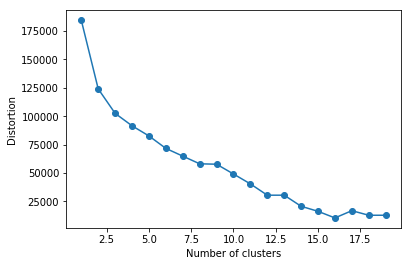

6


In [33]:
n_clusters = elbow_test(pca_df, 10, 20, 300)
print(n_clusters)

In [168]:
km = KMeans(n_clusters=n_clusters, random_state=0)
y = km.fit_predict(pca_df)
idx = np.argsort(km.cluster_centers_.sum(axis=1))
lut = np.zeros_like(idx)
lut[idx] = np.arange(n_clusters)
pca_df['cluster'] = lut[km.labels_]
df['cluster'] = lut[km.labels_]

In [ ]:
We can see that clusters 5 has only 2 elements. 

In [170]:
pca_df[pca_df['cluster']==5]

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,cluster
1270,4.129863,-0.435195,-0.506389,-1.119166,-1.183869,4.596734,26.000275,-0.771787,63.414064,15.450607,-0.327594,5
1947,4.502095,-0.929643,-0.462228,-0.414522,-2.709949,4.989919,26.049687,-0.782688,63.372603,15.404830,-0.344841,5


We can see that the PC9 value is high. It corresponds to the infection reason 'medical'. We can corroborate this by looking at the actual data:  

In [172]:
df[df['cluster']==5]

,sex,country,infection_reason,infection_order,contact_number,state,month,day,age,infection_duration,...,France,Korea,Mongolia,state_Unknown,state_deceased,state_isolated,state_released,female,male,cluster
1271,female,France,medical,0.0,0.0,isolated,3.0,7.0,18.0,11,...,1,0,0,0,0,1,0,1,0,5
1951,male,France,medical,0.0,0.0,Unknown,3.0,11.0,18.0,7,...,1,0,0,1,0,0,0,0,1,5


For cluster 2, PC7 is really high. Which makes sense that is a small cluster since PC7 corresponds to infection reason pilgrimage, and there are few cases in the data frame. We can list those cases:

For the cluster 3, it has high PC9. Which corresponds to infection reason 'medical'.

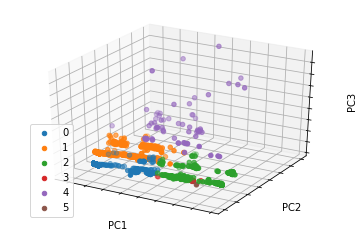

In [183]:
create_3d_scatter(pca_df, 'PC1', 'PC2', 'PC3', 'cluster', n_clusters, '')

From the graph we can see that some of the clusters are distributed according the first 3 principal components.  
However, In this graph, cluster 3 and 4 are not well defined. 

| Cluster | PC1  |  PC2  | PC3  |
| --------|-----:| -----:|-----:|
| 0       | low  |  low  | low  |
| 1       | low  |middle | low  |
| 2       | high |middle | low  |


So, let's graph other components, to see if we can find the meaning of cluster 4. For this we can draw a scatter plot. 

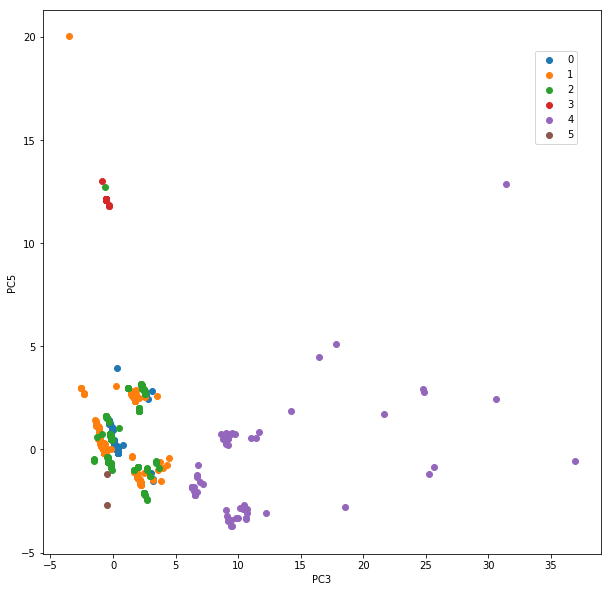

In [196]:
draw_scatter(pca_df, 'PC3', 'PC5', 'cluster', n_clusters, '')

From the scatterplot, we can see that the PC3 values for cluster 4 are bigger than the rest. PC3 referes to  state released. 

In [203]:
df[df['cluster']==4].contact_number.unique()

array([0.00e+00, 4.50e+01, 7.50e+01, 1.60e+01, 9.50e+01, 3.10e+01,
       1.70e+01, 9.00e+00, 1.13e+02, 2.00e+00, 4.30e+01, 4.22e+02,
       3.00e+00, 1.50e+01, 4.50e+02, 2.90e+02, 8.00e+00, 6.80e+01,
       6.00e+00, 1.00e+00, 2.30e+01, 1.20e+01, 4.00e+01, 1.17e+02,
       1.16e+03, 4.70e+01, 7.40e+01])

In [198]:
df[df['cluster']==3].infection_reason.unique()

array(['religious'], dtype=object)